# Import Necessary Libraries and Data

In [134]:
# Import libraries

import os, random, shutil
import cv2
import numpy as np
import pandas as pd
from pathlib import Path


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
# Read directory in

xray_dir = '/Users/Ozymandias/FlatironDSM/Phase4Project/dsc-phase-4-project/chest_xray/'

In [10]:
# Split directory by folder

train_dir = '{}train'.format(xray_dir)
val_dir = '{}val'.format(xray_dir)
test_dir = '{}test'.format(xray_dir)

# EDA

In [95]:
# Define a function to extract images into lists

labels = ['NORMAL', 'PNEUMONIA']
img_size = 256
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [99]:
train = get_data(train_dir)
test = get_data(test_dir)

'NoneType' object is not subscriptable
'NoneType' object is not subscriptable


/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


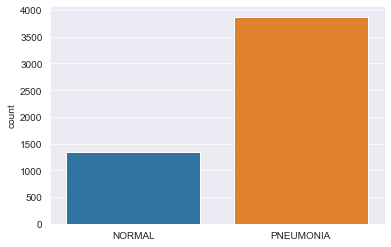

In [102]:
# Separate and plot training images by labels

l = []
for i in train:
    if(i[1] == 0):
        l.append("NORMAL")
    else:
        l.append("PNEUMONIA")
sns.set_style('darkgrid')
sns.countplot(l)

/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

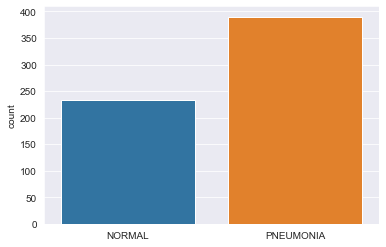

In [181]:
# Separate and plot testing images by labels

l = []
for i in test:
    if(i[1] == 0):
        l.append("NORMAL")
    else:
        l.append("PNEUMONIA")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'PNEUMONIA')

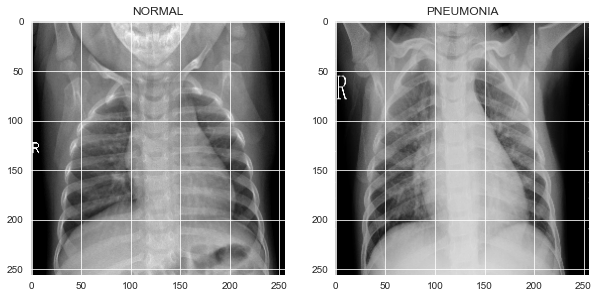

In [183]:
# Plot an example of each label for visual comparison

f = plt.figure(figsize = (10,10))
a1 = f.add_subplot(1,2,1)
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

a2 = f.add_subplot(1, 2, 2)
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

# Preprocessing

## 

In [143]:
# Use Keras ImageDataGenerator to augment input data

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, zoom_range=0.2, width_shift_range=0.1,
                                  height_shift_range=0.1)


train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                        target_size=(150, 150), 
                                                        batch_size=10, 
                                                        class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                        target_size=(150, 150), 
                                                        batch_size=32, 
                                                        class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# The dataset is comprised of three directories; train, validate, and test. The validate directory only has 16 images
# in it which I hypothesize will lead to an unstable model that is over-fit. I will fit a base model using the
# validate files and will then train additional models on the test set and a split set. 

# Modeling

## Base Model

In [77]:
# Instantiate a convolution neural network using convolutional layers, maxpooling layers, a flattened layer, 
# and dropout

basemodel=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(150,150,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [78]:
# Compile the model using the adaptive moment estimation (Adam) convergence algorithm, binary crossentropy as a loss
# metric as there are only two possible outcomes, and accuracy as the evaluation metric. 

basemodel.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

In [72]:
# Check a summary of the model layers and their parameter counts

basemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 17, 17, 128)       0         
__________

In [69]:
# Fit the baseline model using the training and validation data generators 

basemodel_history = basemodel.fit_generator(train_generator, steps_per_epoch=125,
            validation_data = val_generator, validation_steps=16, epochs = 10, verbose = 1)

Epoch 1/10
125/125 [==============================]125/125 [==============================] - 281s 2s/step - loss: 0.5755 - acc: 0.7388 - val_loss: 0.6318 - val_acc: 0.5000

Epoch 2/10
125/125 [==============================]125/125 [==============================] - 251s 2s/step - loss: 0.4612 - acc: 0.7833 - val_loss: 0.5267 - val_acc: 0.6875

Epoch 3/10
125/125 [==============================]125/125 [==============================] - 253s 2s/step - loss: 0.3774 - acc: 0.8220 - val_loss: 0.4251 - val_acc: 0.8750

Epoch 4/10
125/125 [==============================]125/125 [==============================] - 252s 2s/step - loss: 0.3171 - acc: 0.8710 - val_loss: 0.3752 - val_acc: 0.9375

Epoch 5/10
125/125 [==============================]125/125 [==============================] - 263s 2s/step - loss: 0.2817 - acc: 0.8768 - val_loss: 0.5564 - val_acc: 0.7500

Epoch 6/10
125/125 [==============================]125/125 [==============================] - 260s 2s/step - loss: 0.2496 - acc: 0

In [21]:
# Define a function to plot accuracy and loss against epochs 

def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

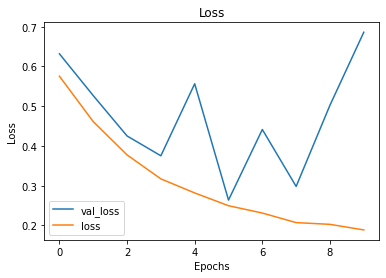

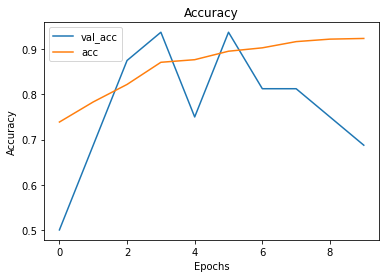

In [70]:
# Call plot function

visualize_training_results(basemodel_history)

### Evaluate Base Model 

In [71]:
# Evaluate accuracy and loss of model against test data

print("Loss of the model is - " , basemodel.evaluate_generator(test_generator, steps=20)[0]*100 , "%")
print("Accuracy of the model is - " , basemodel.evaluate_generator(test_generator, steps=20)[1]*100 , "%")

Loss of the model is -  36.087683378121795 %
Accuracy of the model is -  87.01923076923077 %


## Model without validation

### The first model had much higher loss and lower accuracy that we would like. In order to isolate how much evaluating that model against a validation set with so few observations is impacting loss and accuracy we will model the training and test set using the same model architecture and hyperparamter values

In [147]:
test_model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(150,150,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [148]:
test_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

In [184]:
test_history = test_model.fit_generator(train_generator, steps_per_epoch=125,
            validation_data = test_generator, validation_steps=20, epochs = 10, verbose = 1)

Epoch 1/10
125/125 [==============================]125/125 [==============================] - 260s 2s/step - loss: 0.3408 - acc: 0.8525 - val_loss: 0.4085 - val_acc: 0.8093

Epoch 2/10
125/125 [==============================]125/125 [==============================] - 247s 2s/step - loss: 0.2514 - acc: 0.8980 - val_loss: 0.3548 - val_acc: 0.8526

Epoch 3/10
125/125 [==============================]125/125 [==============================] - 247s 2s/step - loss: 0.2368 - acc: 0.9027 - val_loss: 0.2898 - val_acc: 0.8830

Epoch 4/10
125/125 [==============================]125/125 [==============================] - 250s 2s/step - loss: 0.2236 - acc: 0.9098 - val_loss: 0.3904 - val_acc: 0.8429

Epoch 5/10
125/125 [==============================]125/125 [==============================] - 278s 2s/step - loss: 0.2003 - acc: 0.9237 - val_loss: 0.3200 - val_acc: 0.8862

Epoch 6/10
125/125 [==============================]125/125 [==============================] - 241s 2s/step - loss: 0.1962 - acc: 0

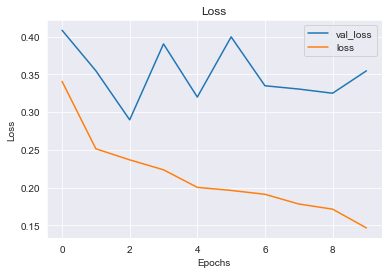

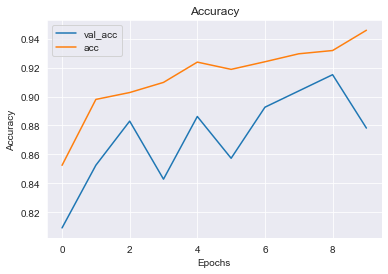

In [185]:
visualize_training_results(test_history)

In [186]:
print("Loss of the model is - " , test_model.evaluate_generator(test_generator, steps=20)[0]*100 , "%")
print("Accuracy of the model is - " , test_model.evaluate_generator(test_generator, steps=20)[1]*100 , "%")

Loss of the model is -  35.47378970453373 %
Accuracy of the model is -  87.82051282051282 %


In [ ]:
# Using the test data instead of the validation data to run the model reduced the loss from 36% to 24% and improved 
# the accuracy from 87% to 92%. These are significant improvements, but now we will try to improve them even more by 
# generating an ample validation set from within the training set.

In [ ]:
Y_pred = test_model.predict_generator(test_generator, steps=20)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

## Modeling w/ Validation Split

In [150]:
train_split_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2, zoom_range=0.2, 
                                   width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2)

train_split_dataset = train_split_datagen.flow_from_directory(train_dir, batch_size=32,
                                                 shuffle=True,
                                                 target_size=(150, 150), 
                                                 subset="training",
                                                 class_mode='binary')


validation_split_dataset = train_split_datagen.flow_from_directory(train_dir, batch_size=32,
                                                 shuffle=True,
                                                 target_size=(150, 150), 
                                                 subset="validation",
                                                 class_mode='binary')

test_split_datagen = ImageDataGenerator(rescale=1./255)

test_split_generator = test_split_datagen.flow_from_directory(test_dir, batch_size=32,
                                                    target_size=(150, 150),  
                                                    class_mode='binary', shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [151]:
split_model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),input_shape=(150,150,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
    
])

In [152]:
split_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

In [153]:
split_model_history = split_model.fit_generator(train_split_dataset, steps_per_epoch=130, 
                                                validation_data= validation_split_dataset, 
                                                validation_steps =32, epochs = 10, verbose = 1)

Epoch 1/10
130/130 [==============================]130/130 [==============================] - 327s 3s/step - loss: 0.5876 - acc: 0.7341 - val_loss: 0.5223 - val_acc: 0.7793

Epoch 2/10
130/130 [==============================]130/130 [==============================] - 281s 2s/step - loss: 0.3775 - acc: 0.8345 - val_loss: 0.3832 - val_acc: 0.8427

Epoch 3/10
130/130 [==============================]130/130 [==============================] - 270s 2s/step - loss: 0.3183 - acc: 0.8688 - val_loss: 0.6000 - val_acc: 0.6973

Epoch 4/10
130/130 [==============================]130/130 [==============================] - 269s 2s/step - loss: 0.3008 - acc: 0.8682 - val_loss: 0.3368 - val_acc: 0.8546

Epoch 5/10
130/130 [==============================]130/130 [==============================] - 269s 2s/step - loss: 0.2627 - acc: 0.8881 - val_loss: 0.3509 - val_acc: 0.8635

Epoch 6/10
130/130 [==============================]130/130 [==============================] - 264s 2s/step - loss: 0.2312 - acc: 0

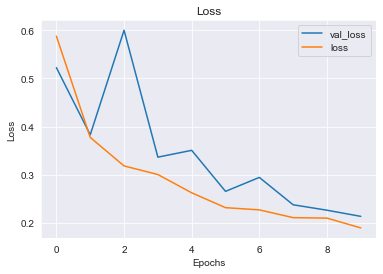

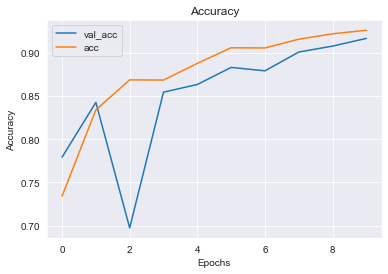

In [154]:
visualize_training_results(split_model_history)

In [155]:
print("Loss of the model is - " , split_model.evaluate_generator(test_generator, steps=20)[0]*100, "%")
print("Accuracy of the model is - " , split_model.evaluate_generator(test_generator, steps=20)[1]*100, "%")

Loss of the model is -  25.22830170316574 %
Accuracy of the model is -  90.86538461538461 %


In [128]:
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
#test_generator.reset()
#pred=split_model.predict_generator(test_generator,
#steps=20, verbose=1)

20/20 [==============================]20/20 [==============================] - 16s 821ms/step



In [131]:
#split_model.evaluate_generator(test_generator, pred)

In [ ]:
#dgen_no_shuffle.reset() 
#y = split_model.predict_generator(dgen_no_shuffle,steps= math.ceil(dgen_no_shuffle.samples//batch_size),workers=8)

In [179]:
print(test_split_generator.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [187]:
test_split_generator.reset()

In [175]:
Y_pred = split_model.predict_generator(test_split_generator, 20)
y_pred = np.argmax(Y_pred, axis=1)

In [180]:
print('Confusion Matrix')
print(confusion_matrix(test_split_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(test_split_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[234   0]
 [390   0]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Ozymandias/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av